In [1]:
import matplotlib as mpl
from matplotlib.colors import get_named_colors_mapping
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
import numpy as np
import vice
import sys
print(sys.version_info)
mpl.rcParams["text.usetex"] = True

sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)


In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

/n/home01/abeane/venv/note/lib/python3.10/site-packages/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


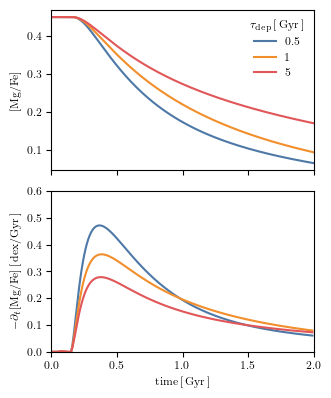

In [3]:
ELEMENTS = ["fe", "mg"]
SFE_TIMESCALES = [0.5, 1, 5] # Gyr -- SFE = 1 / SFE_TIMESCALE
ENDTIME = 2 # Gyr
TIMESTEP_SIZE = 0.01 # Gyr

# setup figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (columnwidth, 1.2*columnwidth), sharex=True)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r'$[\textrm{Mg}/\textrm{Fe}]$')
# ax2.set_ylabel(r'$-\textrm{d}[\textrm{Mg}/\textrm{Fe}]/\textrm{d}\,t\,[\,\textrm{Gyr}^{-1}\,]$')
ax2.set_ylabel(r'$-\partial_t[\textrm{Mg}/\textrm{Fe}]\,[\,\textrm{dex}/\textrm{Gyr}\,]$')
ax2.set_xlabel(r'%\textrm{time}\,[\,\textrm{Gyr}\,]$')
ax1.set_xlim(0, ENDTIME)
# ax2.set_yscale("log")
# ax2.yaxis.set_major_formatter(fsf("%g"))
ax2.set_ylim([0, 0.6])
ax2.set_xlabel(r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')


# Magg et al. (2022) solar abundances and yields from Weinberg et al. (2023)
vice.solar_z["mg"] = 6.71e-4
vice.solar_z["fe"] = 13.7e-4
vice.yields.ccsne.settings["mg"] = 6.52e-4
vice.yields.ccsne.settings["fe"] = 4.73e-4
vice.yields.sneia.settings["mg"] = 0
vice.yields.sneia.settings["fe"] = 0.0012


# run the GCE models
for i in range(len(SFE_TIMESCALES)):
    with vice.singlezone(name = "tmp") as sz:
        # Conroy et al. (2022) one-zone model parameters
        sz.elements = ELEMENTS
        sz.mode = "ifr" # sz.func is the accretion rate as opposed to SFR or gas supply as function of time
        sz.func = lambda t: 5 # Msun/year
        sz.Mg0 = 0 # zero gas supply at time t = 0
        sz.tau_star = SFE_TIMESCALES[i] # the timescale we're varying, Mgas / SFR
        sz.eta = 2 # the mass loading factor (outflow rate / SFR)
        sz.dt = TIMESTEP_SIZE
        out = sz.run(np.arange(0, ENDTIME+TIMESTEP_SIZE, sz.dt), overwrite = True, capture = True)
    kwargs = {
        "c": tb_c[i],
        "label": r"$%g$" % (SFE_TIMESCALES[i])
    }
    dmgfe_dt = [(a - b) / TIMESTEP_SIZE for a, b in zip(
        out.history["[mg/fe]"][:-1], out.history["[mg/fe]"][1:])]
    ax1.plot(out.history["time"], out.history["[mg/fe]"], **kwargs)
    ax2.plot(out.history["time"][:-1], dmgfe_dt, **kwargs)

# kwargs = {
    # "loc": 1,
    # "handlelength": 0,
    # "frameon": False,
    # "fontsize": FONTSIZE
# }
# leg = ax1.legend(**kwargs)
# for i in range(len(COLORS)):
    # leg.get_texts()[i].set_color(COLORS[i])
    # leg.legend_handles[i].set_visible(False)
ax1.legend(title=r'$\tau_{\textrm{dep}}\,[\,\textrm{Gyr}\,]$', frameon=False)
    
plt.tight_layout()
# plt.subplots_adjust(hspace = 0)
plt.savefig("mgfe_vice.pdf")
plt.show()